In [1]:
from pathlib import Path

import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py_vollib.black.implied_volatility as pyv_iv
from py_vollib.helpers import forward_price as pv_forward_price

pd.options.display.width = 140
pd.options.display.max_columns = 20

PROJECT_ROOT = Path(".")
SESSION_FOLDERS = {"ETH": PROJECT_ROOT / "ETH", "RTH": PROJECT_ROOT / "RTH"}
RISK_FREE_RATE = 0.02

# Cleaning ETH and RTH Market Data
We combine extended trading hours (ETH) and regular trading hours (RTH) datasets into tidy
assets and option dataframes ready for downstream analysis.
## Dataset Overview
- **RTH vs ETH**: RTH covers the standard 09:30–16:00 ET NYSE session while ETH captures overnight and
  pre/post-market activity. Comparing both windows is vital because volatility shocks can start or fade outside
  cash hours, yet still influence pricing when the market reopens.
- **SPX**: The S&P 500 index represents the underlying spot level for every SPX option we analyze; tracking it
  alongside option quotes lets us compute moneyness, spot returns, and link surface shifts to index swings.
- **VIX**: The CBOE Volatility Index summarizes the 30-day implied variance from listed options, so monitoring
  it provides a benchmark for whether our bespoke volatility surfaces are consistent with market sentiment.
- **ES futures**: Front-month E-mini S&P 500 futures trade nearly 24 hours, offering a tradable proxy for SPX
  during ETH. Their bid/ask levels reveal how much of a move occurs before the cash market opens and aid in
  aligning option timestamps with corresponding underlying prices.
- **SPX options**: These listed index options across strikes/expiries supply the bid/ask quotes feeding our
  implied-volatility surface, risk-neutral PDF extraction, and hedging analysis; clean quotes are essential for
  reliable Greeks and surface diagnostics.

# Imports and Paths

## Helper Functions

In [2]:
# Helper routines: parsing CSVs, melting option quotes, and orchestrating session-level loads.
def parse_timestamped_csv(csv_path: Path) -> pd.DataFrame:
    """Load a CSV whose first column stores timestamps and return a tidy timestamp column."""
    frame = pd.read_csv(csv_path, index_col=0)
    frame.index = pd.to_datetime(frame.index)
    frame = frame.reset_index().rename(columns={"index": "timestamp"})
    return frame


def melt_option_quotes(frame: pd.DataFrame, value_name: str) -> pd.DataFrame:
    """Convert wide strike columns into long format for a single quote side."""
    melted = frame.melt(id_vars="timestamp", var_name="strike", value_name=value_name)
    melted["strike"] = pd.to_numeric(melted["strike"], errors="coerce")
    melted[value_name] = pd.to_numeric(melted[value_name], errors="coerce")
    return melted


def load_option_book(assets: pd.DataFrame | None = None) -> pd.DataFrame:
    """Load and merge bid/ask quotes for calls and puts acrjkjkjkjkjkjkjkjkjkjkjkjkoss sessions."""
    if assets is None:
        assets = load_assets()

    records: list[pd.DataFrame] = []
    for option_type in ("call", "put"):
        for session, folder in SESSION_FOLDERS.items():
            ask_files = sorted(folder.glob(f"*_{option_type}_ask_*.csv"))
            for ask_path in ask_files:
                stem_parts = ask_path.stem.split("_")
                expiry = pd.to_datetime(stem_parts[-1])
                bid_path = ask_path.with_name(ask_path.name.replace("_ask_", "_bid_"))

                # Convert the wide strike grid into tidy bid/ask quote tables.
                ask_frame = melt_option_quotes(parse_timestamped_csv(ask_path), "ask")
                bid_frame = melt_option_quotes(parse_timestamped_csv(bid_path), "bid")
                merged = pd.merge(
                    ask_frame, bid_frame, on=["timestamp", "strike"], how="outer"
                )

                # Replace placeholder -1 quotes with NaN and remove empty markets.
                merged[["bid", "ask"]] = merged[["bid", "ask"]].replace(-1, np.nan)
                merged = merged.dropna(subset=["bid", "ask"])

                # Attach contract metadata and maturity measures.
                merged["expiry"] = expiry
                merged["session"] = session
                merged["option_type"] = option_type

                time_delta_days = (
                    merged["expiry"] - merged["timestamp"]
                ).dt.total_seconds() / 86400
                merged["time_to_maturity_days"] = np.floor(time_delta_days).astype(
                    "Int64"
                )
                merged["time_to_maturity_years"] = time_delta_days / 365.25

                # Use the midpoint as the transactable option value.
                merged["option_price"] = merged[["bid", "ask"]].mean(axis=1)

                records.append(merged)

    # Combine all sessions/files into one chronologically ordered long DataFrame.
    long_df = pd.concat(records, ignore_index=True)

    # Prepare the SPX snapshot and forward proxy to align with option quotes.
    asset_slice = assets[["timestamp", "session", "SPX", "ES_BID", "ES_ASK"]].copy()
    asset_slice["forward_price"] = asset_slice[["ES_BID", "ES_ASK"]].mean(axis=1)
    asset_slice = asset_slice.drop(columns=["ES_BID", "ES_ASK"])

    # Merge the nearest prior asset snapshot within each session onto every option row.
    long_df["session"] = long_df["session"].astype("category")
    asset_slice["session"] = asset_slice["session"].astype("category")

    # Sort cols before we can use merge_asof
    long_df = long_df.sort_values("timestamp").reset_index(drop=True)
    asset_slice = asset_slice.sort_values("timestamp").reset_index(drop=True)

    long_df = pd.merge_asof(
        long_df,
        asset_slice,
        on="timestamp",
        by="session",
        direction="backward",
        allow_exact_matches=True,
    )

    # Mark the strike(s) closest to the forward price as ATM per timestamp/expiry/session.
    long_df["is_atm"] = False
    atm_mask = (
        long_df["forward_price"].notna()
        & long_df["strike"].notna()
        & long_df["timestamp"].notna()
        & long_df["expiry"].notna()
    )
    if atm_mask.any():
        subset = long_df.loc[
            atm_mask, ["timestamp", "expiry", "session", "strike", "forward_price"]
        ].copy()
        subset["distance"] = (subset["strike"] - subset["forward_price"]).abs()
        min_distance = subset.groupby(["timestamp", "expiry", "session"])[
            "distance"
        ].transform("min")
        long_df.loc[subset.index, "is_atm"] = subset["distance"].eq(min_distance)

    # Flag out-of-the-money contracts relative to the forward.
    long_df["is_otm"] = (
        (long_df["option_type"] == "call")
        & (long_df["strike"] > long_df["forward_price"])
    ) | (
        (long_df["option_type"] == "put")
        & (long_df["strike"] < long_df["forward_price"])
    )

    # Compute py_vollib-consistent intrinsic values using discounted forward payoffs.
    long_df = long_df.dropna(
        subset=["option_price", "SPX", "strike", "time_to_maturity_years"]
    )
    undiscounted_intrinsic = np.where(
        long_df["option_type"] == "call",
        np.maximum(long_df["forward_price"] - long_df["strike"], 0.0),
        np.maximum(long_df["strike"] - long_df["forward_price"], 0.0),
    )
    discount_factor = np.exp(-RISK_FREE_RATE * long_df["time_to_maturity_years"])
    long_df["intrinsic_value"] = undiscounted_intrinsic * discount_factor

    # Enforce strictly positive time value to avoid numerical issues with IV solvers.
    time_value = long_df["option_price"] - long_df["intrinsic_value"]
    time_value_tol = 1e-6
    long_df = long_df[time_value > time_value_tol].copy()

    return long_df


def load_assets() -> pd.DataFrame:
    """Load SPX/ES/VIX snapshots from both sessions."""
    frames: list[pd.DataFrame] = []
    for session, folder in SESSION_FOLDERS.items():
        for csv_path in sorted(folder.glob("*_assets.csv")):
            frame = parse_timestamped_csv(csv_path)
            frame["session"] = session
            frames.append(frame)

    assets = pd.concat(frames, ignore_index=True)
    assets = assets.astype(
        {
            "SPX": "Float64",
            "ES_BID": "Float64",
            "ES_ASK": "Float64",
            "VIX": "Float64",
            "session": "category",
        }
    )
    assets = assets.sort_values("timestamp").reset_index(drop=True)
    return assets

## Visualization Utilities

In [3]:
from collections.abc import Mapping, Sequence

# Provide reusable plotting helpers for exploratory analysis.
SESSION_COLORS = {"RTH": "#2ca02c", "ETH": "#1f77b4"}


def _shade_session_blocks(ax, series: pd.DataFrame) -> None:
    """Overlay lightly shaded regions for ETH and RTH stretches."""
    legend_labels = set()
    session_switch = series["session"].ne(series["session"].shift()).cumsum()
    for _, block in series.groupby(session_switch):
        session_name = block["session"].iloc[0]
        color = SESSION_COLORS.get(session_name, "gray")
        ax.axvspan(
            block["timestamp"].iloc[0],
            block["timestamp"].iloc[-1],
            color=color,
            alpha=0.08,
            label=session_name if session_name not in legend_labels else None,
        )
        legend_labels.add(session_name)


def _shade_weekends(ax, series: pd.DataFrame) -> None:
    """Shade weekend periods to highlight market closures."""
    if series.empty:
        return
    start = series["timestamp"].min().normalize()
    end = series["timestamp"].max().normalize()
    dates = pd.date_range(start, end, freq="D")
    weekend_label_added = False
    for day in dates:
        if day.dayofweek == 5:  # Saturday marks the start of the weekend
            ax.axvspan(
                day,
                day + pd.Timedelta(days=2),
                color="gray",
                alpha=0.12,
                label="Weekend" if not weekend_label_added else None,
            )
            weekend_label_added = True


def plot_timeseries(
    data: pd.DataFrame,
    column: str,
    label: str,
    session: str | None = None,
    line_color: str = "black",
) -> None:
    """Display a single time series with ETH/RTH overlays and weekend cues."""
    subset = data.copy()
    if session is not None:
        subset = subset[subset["session"] == session]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        subset["timestamp"],
        subset[column],
        color=line_color,
        linewidth=1.5,
        label=label,
    )

    _shade_session_blocks(ax, subset)
    _shade_weekends(ax, subset)

    ax.set_ylabel(label)
    ax.set_xlabel("Timestamp")
    ax.set_title(f"{label} Over Time" + (f" - {session}" if session else ""))
    ax.grid(True, linestyle="--", alpha=0.3)
    event_date = pd.Timestamp("2025-04-02 16:00:00")
    ax.axvline(
        event_date,
        color="red",
        linestyle=":",
        linewidth=2,
        label="Liberation Day Tariffs (2 Apr 2025)",
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best")
    fig.autofmt_xdate()
    plt.tight_layout()


def plot_vol_smiles_by_period(
    options: pd.DataFrame,
    period: str,
    *,
    event_day: pd.Timestamp = pd.Timestamp("2025-04-02 16:00:00"),
    maturity_col: str = "time_to_maturity_days",
    forward_col: str = "forward_price",
    strike_col: str = "strike",
    iv_col: str = "implied_vol",
    min_quotes: int = 5,
) -> None:
    """Plot volatility smiles (IV vs log-moneyness) for each maturity bucket within a given event period."""
    if options.empty:
        raise ValueError("No option data provided for plotting.")

    timestamps = options["timestamp"]

    # 1) Select the event window: before / during / after.
    event_ts = event_day
    # End of the event day = midnight of the *next* day
    event_day_end = pd.Timestamp("2025-04-03 09:30:00")

    period_lower = period.lower()
    if period_lower == "before":
        mask = timestamps < event_ts
        title_fragment = "Before Liberation Day"
    elif period_lower == "during":
        mask = (timestamps >= event_ts) & (timestamps < event_day_end)
        title_fragment = "During Liberation Day"
    elif period_lower == "after":
        mask = timestamps >= event_day_end
        title_fragment = "After Liberation Day"
    else:
        raise ValueError("period must be one of {'before', 'during', 'after'}")

    # 2) Filter to the chosen period and drop unusable rows.
    subset = (
        options.loc[mask]
        .dropna(subset=[forward_col, strike_col, iv_col, maturity_col])
        .copy()
    )
    if subset.empty:
        raise ValueError(f"No quotes available for period '{period}'.")

    # Require positive forward and strike for log(K/F).
    subset = subset[(subset[forward_col] > 0) & (subset[strike_col] > 0)].copy()
    if subset.empty:
        raise ValueError(
            f"No valid quotes with positive {forward_col} and {strike_col} for period '{period}'."
        )

    # 3) Compute log-moneyness: k = ln(K / F).
    subset["log_moneyness"] = np.log(subset[strike_col] / subset[forward_col])

    # 4) Bucket by maturity (days).
    subset[maturity_col] = subset[maturity_col].astype(int)
    ordered_maturities = sorted(subset[maturity_col].unique())

    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(ordered_maturities)))

    # 5) Plot IV vs log-moneyness for each maturity.
    plotted_any = False
    for color, maturity in zip(colors, ordered_maturities):
        maturity_slice = subset[subset[maturity_col] == maturity]
        maturity_slice = maturity_slice.sort_values("log_moneyness")
        if len(maturity_slice) < min_quotes:
            continue

        ax.plot(
            maturity_slice["log_moneyness"],
            maturity_slice[iv_col],
            label=f"{maturity}d",
            color=color,
            linewidth=1.5,
        )
        plotted_any = True

    if not plotted_any:
        raise ValueError(f"Not enough quotes to plot smiles for period '{period}'.")

    ax.set_title(f"Volatility Smiles {title_fragment}")
    ax.set_xlabel("Log-moneyness  ln(K / F)")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(title="TTM (days)", loc="best")
    plt.tight_layout()


def plot_single_ttm_smiles(
    options: pd.DataFrame,
    period_configs: Mapping[str, int]
    | Sequence[tuple[str, int]]
    | Sequence[tuple[str, int, str]],
    *,
    event_day: pd.Timestamp = pd.Timestamp("2025-04-02 16:00:00"),
    maturity_col: str = "time_to_maturity_days",
    forward_col: str = "forward_price",
    strike_col: str = "strike",
    iv_col: str = "implied_vol",
    min_quotes: int = 5,
    maturity_tolerance: int = 0,
    color_map: dict[str, str] | None = None,
    selected_periods: Sequence[str] | None = None,
    plot_title: str | None = None,
) -> None:
    """Plot a single target TTM smile for each requested period.

    Set ``selected_periods`` to a subset such as ("before", "during") to
    compare only those windows without editing the base configuration, and
    provide ``plot_title`` to override the default chart title.
    """

    def _period_mask(timestamps: pd.Series, window: str) -> pd.Series:
        event_end = pd.Timestamp("2025-04-03 09:30:00")
        if window == "before":
            return timestamps < event_day
        if window == "during":
            return (timestamps >= event_day) & (timestamps < event_end)
        if window == "after":
            return timestamps >= event_end
        raise ValueError("period must be one of {'before', 'during', 'after'}")

    if options.empty:
        raise ValueError("No option data provided for plotting.")

    if isinstance(period_configs, Mapping):
        configs = [(period, ttm, None) for period, ttm in period_configs.items()]
    else:
        configs = []
        for entry in period_configs:
            if isinstance(entry, str):
                raise TypeError(
                    "Sequence-based configs must supply (period, maturity) tuples."
                )
            length = len(entry)
            if length == 2:
                period, ttm = entry
                label = None
            elif length == 3:
                period, ttm, label = entry
            else:
                raise ValueError(
                    "Configs must be (period, maturity) or (period, maturity, label)."
                )
            configs.append((period, ttm, label))

    if not configs:
        raise ValueError("period_configs cannot be empty.")

    if selected_periods is not None:
        filtered: list[tuple[str, int, str | None]] = []
        for period_label in selected_periods:
            matches = [cfg for cfg in configs if cfg[0] == period_label]
            if not matches:
                raise ValueError(
                    f"Requested period '{period_label}' not found in period_configs."
                )
            filtered.extend(matches)
        configs = filtered

    palette = color_map or {
        "before": "#4e79a7",
        "during": "#f28e2b",
        "after": "#e15759",
    }

    fig, ax = plt.subplots(figsize=(10, 5))
    plotted_periods: list[str] = []

    for period, target_ttm, custom_label in configs:
        mask = _period_mask(options["timestamp"], period)
        subset = options.loc[mask].dropna(
            subset=[forward_col, strike_col, iv_col, maturity_col]
        )
        if subset.empty:
            continue

        subset = subset[(subset[forward_col] > 0) & (subset[strike_col] > 0)]
        if subset.empty:
            continue

        maturity_values = subset[maturity_col].astype(float)
        subset = subset[(maturity_values - target_ttm).abs() <= maturity_tolerance]
        if len(subset) < min_quotes:
            continue

        subset = subset.copy()
        subset["log_moneyness"] = np.log(subset[strike_col] / subset[forward_col])
        subset = subset.sort_values("log_moneyness")

        base_label = custom_label or period.capitalize()
        label = f"{base_label} (TTM {int(target_ttm)})"
        ax.plot(
            subset["log_moneyness"],
            subset[iv_col],
            label=label,
            color=palette.get(period, None),
            linewidth=1.8,
        )
        plotted_periods.append(period)

    if not plotted_periods:
        raise ValueError(
            "No period had enough quotes to plot a single-TTM smile. "
            "Check period_maturities, tolerance, or min_quotes."
        )

    ax.set_title(plot_title or "Single-TTM Volatility Smiles")
    ax.set_xlabel("Log-moneyness  ln(K / F)")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="best")
    plt.tight_layout()

# Start
## Load Assets Across Sessions

In [4]:
# Load, clean, and combine SPX, ES, and VIX snapshots from ETH and RTH.
assets_df = load_assets()
assets_df.head()

/var/folders/p3/7gy013yx2hn3mns87ysh4z4w0000gn/T/ipykernel_11207/1006539699.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  assets = pd.concat(frames, ignore_index=True)


,timestamp,SPX,ES_BID,ES_ASK,VIX,session
0,2025-04-01 09:31:21.491248,5590.32,5631.75,5632.0,22.66,RTH
1,2025-04-01 09:31:24.535800,5590.7,5631.75,5632.0,22.66,RTH
2,2025-04-01 09:31:27.582698,5589.06,5629.5,5629.75,22.66,RTH
3,2025-04-01 09:31:30.632772,5588.66,5630.5,5630.75,22.66,RTH
4,2025-04-01 09:31:33.638817,5588.82,5629.75,5630.0,22.69,RTH


In [5]:
assets_df.dtypes

timestamp    datetime64[ns]
SPX                 Float64
ES_BID              Float64
ES_ASK              Float64
VIX                 Float64
session            category
dtype: object

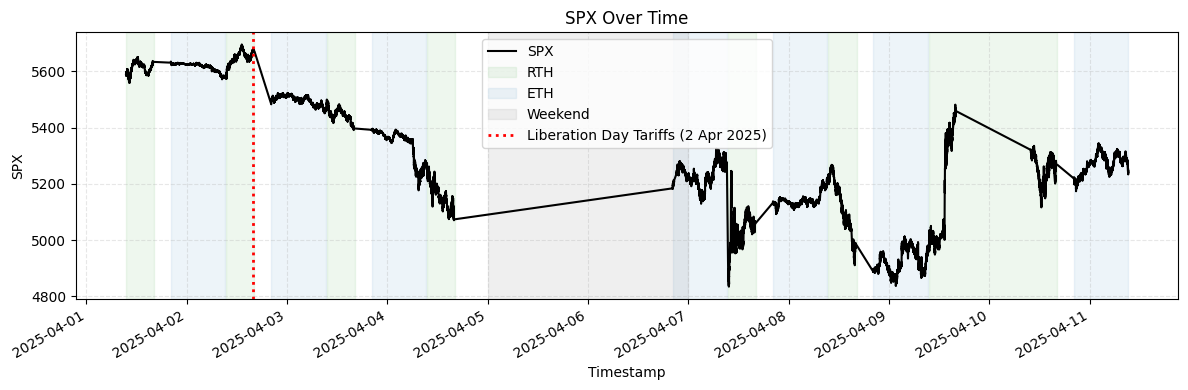

In [6]:
# Visualize SPX over time.
plot_timeseries(assets_df, column="SPX", label="SPX")
plt.show()

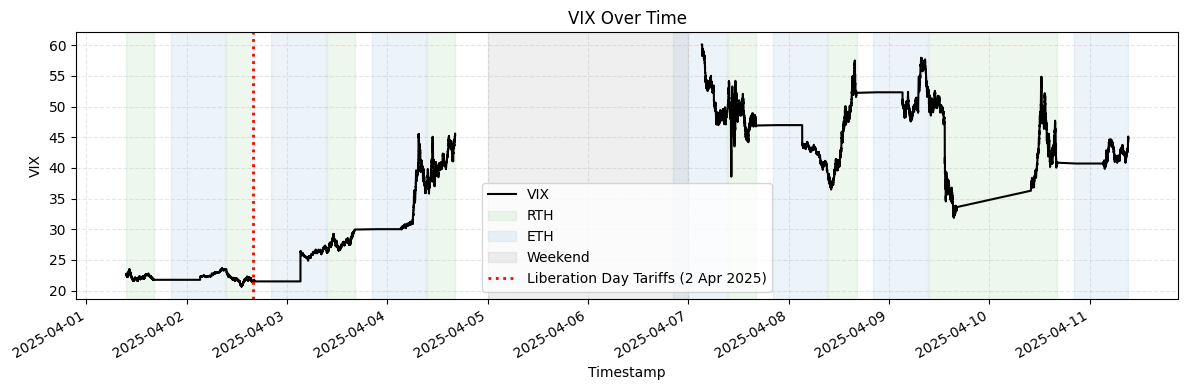

In [7]:
# Visualize VIX over time.
plot_timeseries(assets_df, column="VIX", label="VIX")
plt.show()

## Load Option Quotes

In [8]:
# Build the consolidated option dataframe with bid/ask/mid quotes.
options_df = load_option_book(assets_df)
options_df.head()

/var/folders/p3/7gy013yx2hn3mns87ysh4z4w0000gn/T/ipykernel_11207/1006539699.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  min_distance = subset.groupby(["timestamp", "expiry", "session"])[


,timestamp,strike,ask,bid,expiry,session,option_type,time_to_maturity_days,time_to_maturity_years,option_price,SPX,forward_price,is_atm,is_otm,intrinsic_value
1,2025-04-01 09:31:21.491248,6050.0,453.5,445.9,2025-04-16,RTH,put,14,0.039981,449.70,5590.32,5631.875,False,False,417.790789
2,2025-04-01 09:31:21.491248,6025.0,428.7,421.2,2025-04-16,RTH,put,14,0.039981,424.95,5590.32,5631.875,False,False,392.810772
3,2025-04-01 09:31:21.491248,6000.0,404.1,396.6,2025-04-16,RTH,put,14,0.039981,400.35,5590.32,5631.875,False,False,367.830754
4,2025-04-01 09:31:21.491248,5975.0,379.6,372.1,2025-04-16,RTH,put,14,0.039981,375.85,5590.32,5631.875,False,False,342.850737
5,2025-04-01 09:31:21.491248,5950.0,355.3,347.9,2025-04-16,RTH,put,14,0.039981,351.60,5590.32,5631.875,False,False,317.870720


## Filter ATM/OTM Options via Forward and Compute IV

In [9]:
# Use the forward price from load_option_book to identify ATM/OTM quotes and compute IVs.
valid_quotes = options_df.dropna(
    subset=["forward_price", "option_price", "strike", "time_to_maturity_years"]
)
valid_quotes = valid_quotes[valid_quotes["time_to_maturity_years"] > 0].copy()

atm_otm_options = valid_quotes[valid_quotes["is_atm"] | valid_quotes["is_otm"]].copy()


def _compute_implied_vol(row: pd.Series) -> float:
    flag = "c" if row["option_type"] == "call" else "p"
    return pyv_iv.implied_volatility(
        row["option_price"],
        row["forward_price"],
        row["strike"],
        row["time_to_maturity_years"],
        RISK_FREE_RATE,
        flag,
    )


atm_otm_options["implied_vol"] = atm_otm_options.apply(_compute_implied_vol, axis=1)
atm_otm_options.head()

,timestamp,strike,ask,bid,expiry,session,option_type,time_to_maturity_days,time_to_maturity_years,option_price,SPX,forward_price,is_atm,is_otm,intrinsic_value,implied_vol
39,2025-04-01 09:31:21.491248,5625.0,109.7,107.6,2025-04-16,RTH,put,14,0.039981,108.65,5590.32,5631.875,True,True,0.0,0.353180
40,2025-04-01 09:31:21.491248,5600.0,98.7,96.6,2025-04-16,RTH,put,14,0.039981,97.65,5590.32,5631.875,False,True,0.0,0.356524
41,2025-04-01 09:31:21.491248,5575.0,88.4,86.9,2025-04-16,RTH,put,14,0.039981,87.65,5590.32,5631.875,False,True,0.0,0.360342
42,2025-04-01 09:31:21.491248,5025.0,8.4,7.9,2025-04-16,RTH,put,14,0.039981,8.15,5590.32,5631.875,False,True,0.0,0.495931
43,2025-04-01 09:31:21.491248,5000.0,7.8,7.4,2025-04-16,RTH,put,14,0.039981,7.60,5590.32,5631.875,False,True,0.0,0.506194


## Visualise IV smile for each TTM (day) for before, during and after Liberation Day

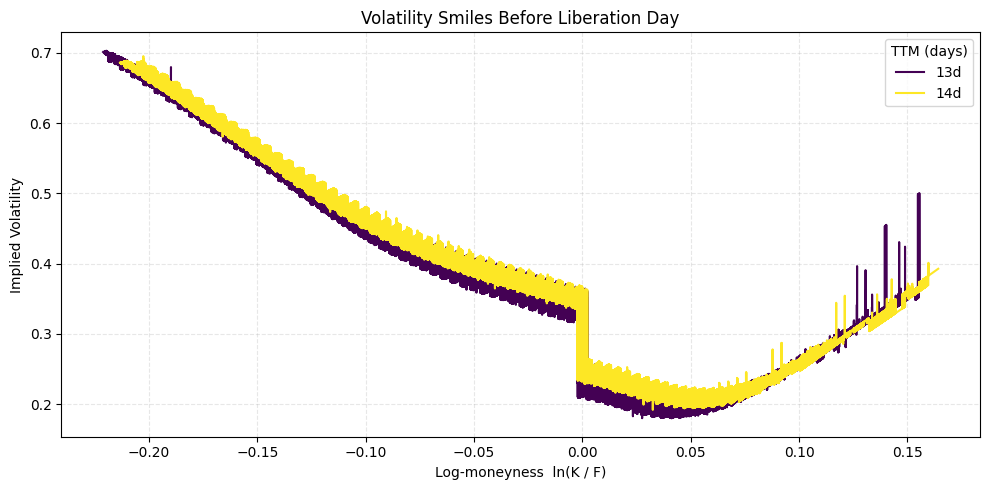

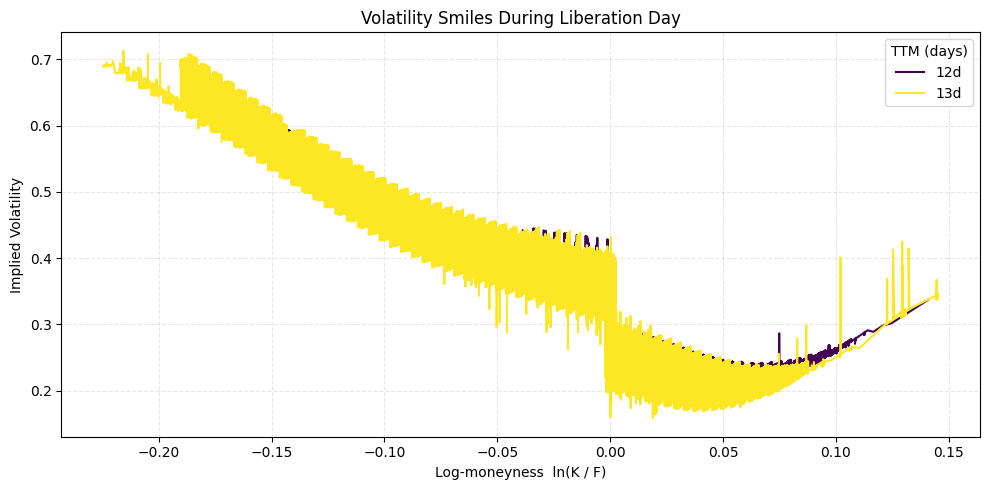

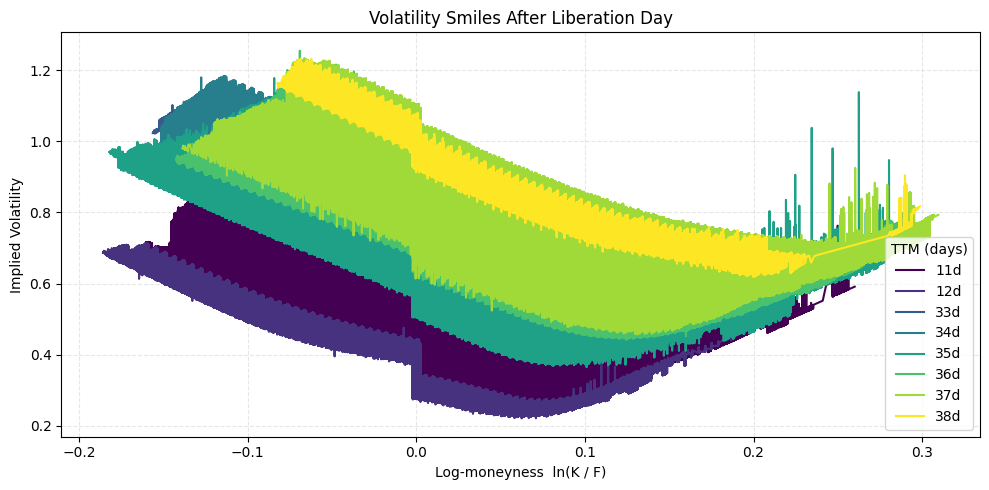

In [10]:
# Plot 15-day volatility smiles for the three event windows.
subset = atm_otm_options.dropna(
    subset=["time_to_maturity_days", "implied_vol", "strike", "timestamp"]
).copy()

for period in ("before", "during", "after"):
    plot_vol_smiles_by_period(subset, period, min_quotes=3)
    plt.show()

## Visualise IV smile for before vs during, and before vs after

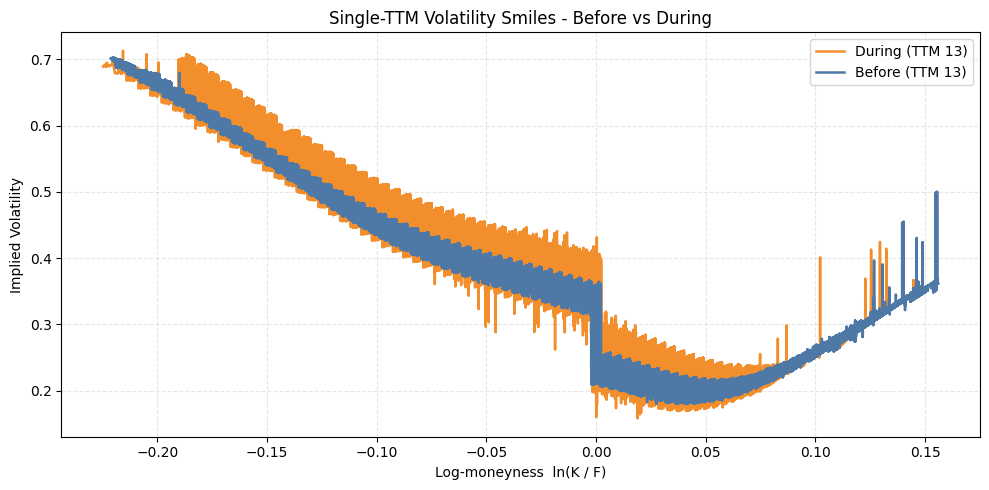

In [11]:
# Compare before vs during using a shared 13-day maturity target.
period_configs1 = {
    "before": 13,
    "during": 13,
    "after": 12,
}
plot_single_ttm_smiles(
    atm_otm_options,
    period_configs1,
    min_quotes=3,
    selected_periods=("during", "before"),
    plot_title="Single-TTM Volatility Smiles - Before vs During",
)
plt.show()

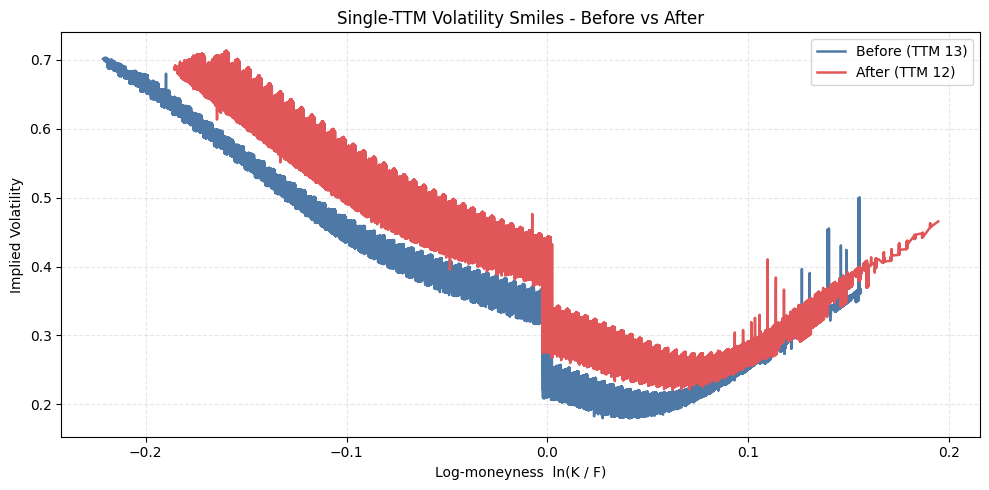

In [12]:
# Compare before vs after using dedicated 13d/12d maturities.
period_configs2 = {
    "before": 13,
    "during": 13,
    "after": 12,
}
plot_single_ttm_smiles(
    atm_otm_options,
    period_configs2,
    min_quotes=3,
    selected_periods=("before", "after"),
    plot_title="Single-TTM Volatility Smiles - Before vs After",
)
plt.show()